# Exp11. (1) Apple Stock Prediction

## Step 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    135.389999
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
Name: Close, dtype: float64

## Step 2 : 각종 전처리 수행
### 결측치 처리

In [2]:
# 결측치 확인. 시계열에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 이 데이터에는 결측치가 없지만, 결측치가 혹시 있다면 처리해야 한다. 결측치는 통계 분석 시에 많은 오류를 일으키며 분석 결과에도 영향을 미치기 때문이다. 
1. 결측치가 있는 데이터를 모두 삭제(drop)
2. 결측치 양 옆의 값들을 이용해 적절히 보간(interpolate)하여 대입

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

- 시간을 index로 갖는 시계열 데이터이기 때문에 삭제보다는 보간(interpolate)한다.  


### 로그 변환

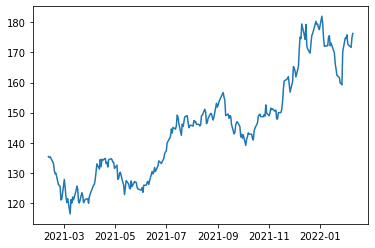

In [4]:
plt.plot(ts)
plt.show()

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()  # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

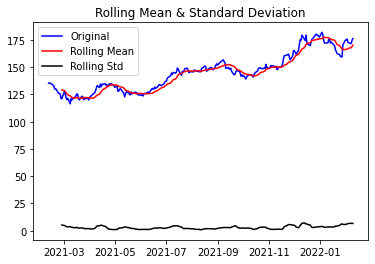

In [6]:
plot_rolling_statistics(ts, window=12)

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공한느 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리해 출력
    print('Result of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
augmented_dickey_fuller_test(ts)

Result of Dickey-Fuller Test: 
Test Statistic                  -0.336113
p-value                          0.920232
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


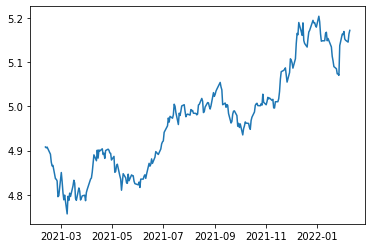

In [9]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

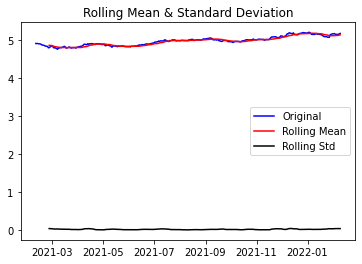

In [10]:
plot_rolling_statistics(ts_log, window=12)

In [11]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test: 
Test Statistic                  -0.410001
p-value                          0.908416
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 사실 로그 변환 전에도 그래프를 정성적으로 보았을 때, 노드에서 봤던 예시만큼 시간 추이에 다른 분산이 증가하는 양상은 아니어서, 로그 변환을 굳이 해야하나 고민했다. 
- 그래서 로그 변환 전후의 ADT Test 결과를 보니 p-value가 0.92에서 0.90으로 소폭 감소하였다. 
- 소폭이라도.. 감소를 했으니 일단 로그 변환은 적용해보기로 했다.  


## Step 3 : 시계열 안정성 분석
`statsmodel` 라이브러리 안에는 `seasonal_decompose` 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능이 있다.  
이 기능을 활용하면 훨신 안정적인 시계열을 분리할 수 있다고 한다. 

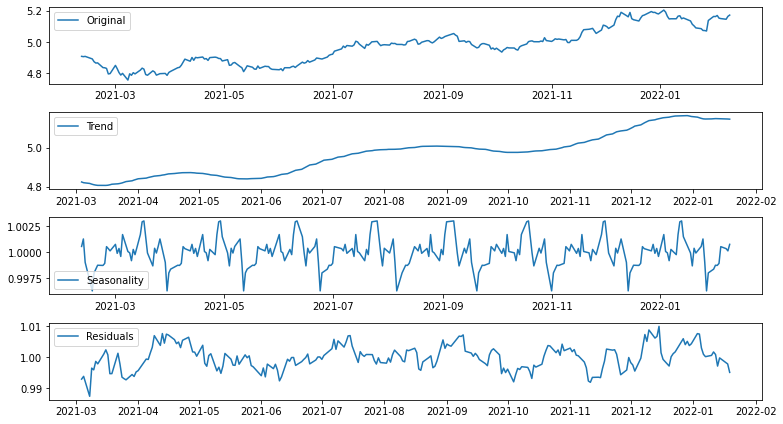

In [12]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세 (시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- multiplicative 모델은 origin = trend * seasonal * residual로 나눠 분석한 모델이다. 
- multiplicative 모델을 활용하려면 데이터에 0이 존재하면 된다. 0이 존재하면 데이터를 분해할 수가 없다고 한다. 
- multiplicative 모델은 분해값들의 곱인 비율로 이루어져 있어서 트렌드에 맞게 seasonal 데이터가 변화한다. 

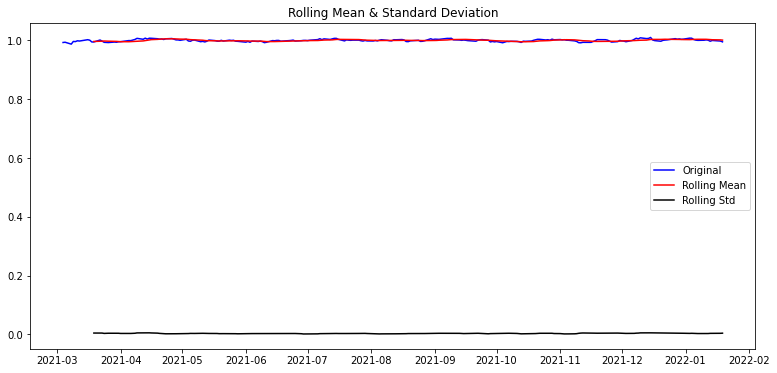

In [13]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Result of Dickey-Fuller Test: 
Test Statistic                  -4.747775
p-value                          0.000068
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


- `Decomposing`을 통해 얻은 `Residual`은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열인가..?  


## Step 4 : 학습, 테스트 데이터셋 생성

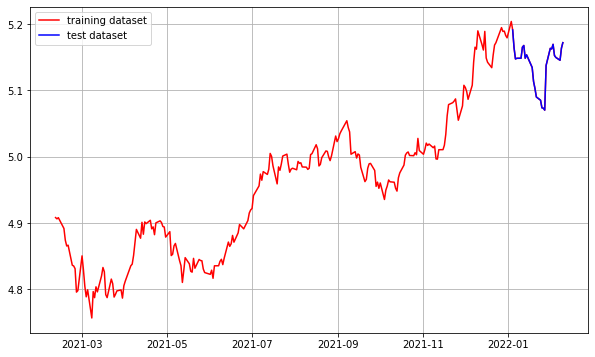

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

- 시계열 데이터에서 9:1의 비율로 학습 데이터와 테스트 데이터를 분리했다. 시계열 예측이니 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다. 

In [16]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    4.908159
2021-02-11    4.906237
Name: Close, dtype: float64
(227,)
(26,)


## Step 5 : 적정 ARIMA 모수 찾기

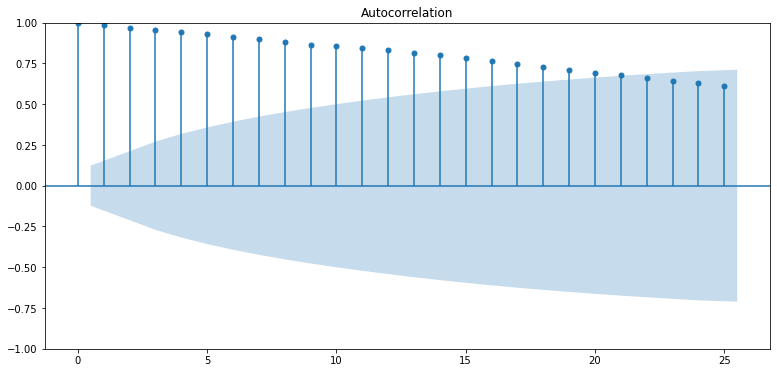

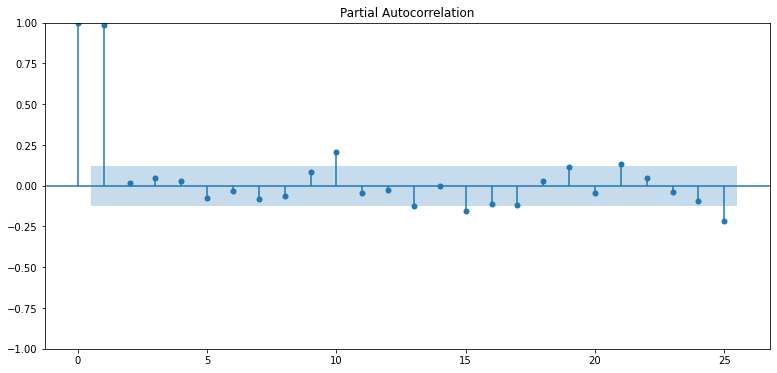

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)  # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 봤을 때, p=1이 적합할 것이다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있다. 
- PACF가 0이라는 것은 현재 데이터와 p 시점 떨어진 이전의 데이터가 상관도 0, 즉 아무 상관이 없는 데이터이기 때문에 고려할 필요가 없다. 
- ACF는 점진적으로 감소하고 있기에 AR(1) 모델에 유사한 형태일 것이다. q에 대해서는 적합한 값이 없어 보인다. 
- 노드에서 MA를 고려할 필요가 없다면 q=0으로 둘 수 있다고 했는데, 바꿔봐도 좋을 것 같다. 

Result of Dickey-Fuller Test: 
Test Statistic                -9.969701e+00
p-value                        2.257472e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


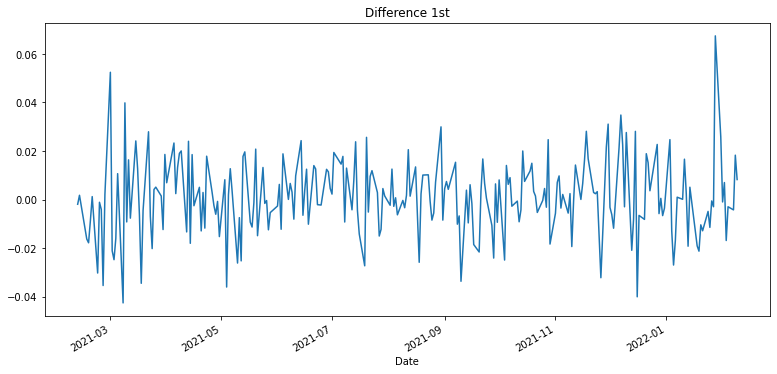

In [18]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Result of Dickey-Fuller Test: 
Test Statistic                -7.667778e+00
p-value                        1.623806e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


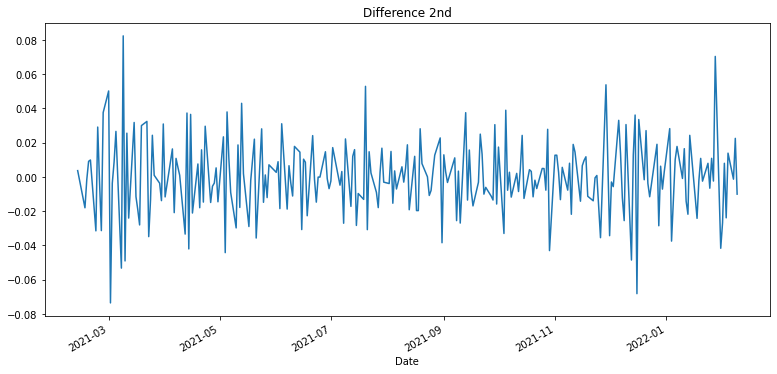

In [19]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- d값은 0으로 줘도 충분할 것 같다. 몇 번 더 시도해봐야겠지만...  


## Step 6 : ARIMA 모델 훈련과 테스트

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 626.711
Date:                Thu, 10 Feb 2022   AIC                          -1247.422
Time:                        14:24:18   BIC                          -1237.147
Sample:                             0   HQIC                         -1243.275
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0123      0.123     40.760      0.000       4.771       5.253
ar.L1          0.9938      0.007    142.924      0.000       0.980       1.007
sigma2         0.0002   1.95e-05     11.751      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


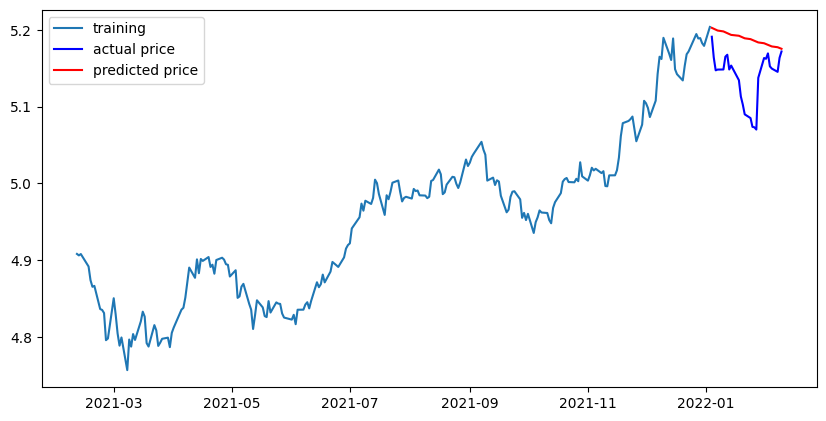

In [21]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  109.68461898079589
MAE:  8.747427137342957
RMSE:  10.473042489209899
MAPE: 5.25%


- 음... 예측이 좀 기대 밖으로 나오긴 했는데... 저 부분의 급격한 감소나 증가를 예측하기 힘들었던 것 같다. 
- d값을 1로도 해봤는데 오히려 예측을 더 이상하게 했다. 
- q값의 변화는 예측에 거의 영향을 미치지 않는 것 같다. 

# (2) Google Stock Prediction


## Step 1 : 시계열 데이터 준비

In [23]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    2095.379883
2021-02-11    2095.889893
2021-02-12    2104.110107
2021-02-16    2121.899902
2021-02-17    2128.310059
Name: Close, dtype: float64

## Step 2 : 각종 전처리 수행
### 결측치 처리

In [24]:
# 결측치 확인. 시계열에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 이 데이터에는 결측치가 없지만, 결측치가 혹시 있다면 처리해야 한다. 결측치는 통계 분석 시에 많은 오류를 일으키며 분석 결과에도 영향을 미치기 때문이다. 
1. 결측치가 있는 데이터를 모두 삭제(drop)
2. 결측치 양 옆의 값들을 이용해 적절히 보간(interpolate)하여 대입

In [25]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

- 시간을 index로 갖는 시계열 데이터이기 때문에 삭제보다는 보간(interpolate)한다.  


### 로그 변환

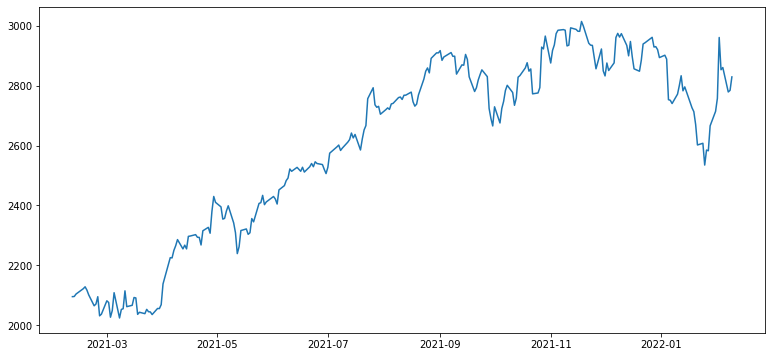

In [26]:
plt.plot(ts)
plt.show()

In [27]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()  # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

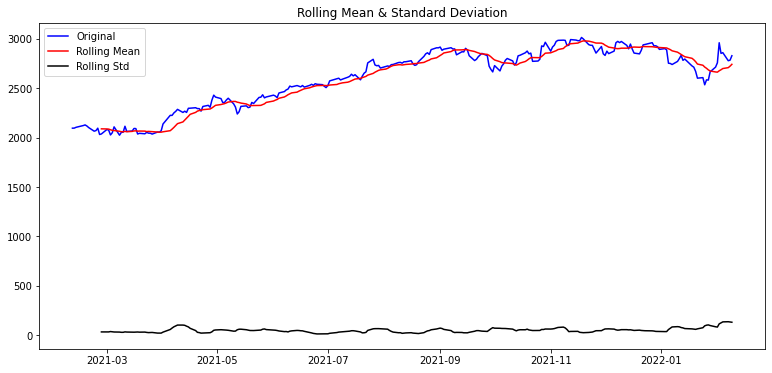

In [28]:
plot_rolling_statistics(ts, window=12)

In [29]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리해 출력
    print('Result of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [30]:
augmented_dickey_fuller_test(ts)

Result of Dickey-Fuller Test: 
Test Statistic                  -1.477549
p-value                          0.544587
#Lags Used                       4.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


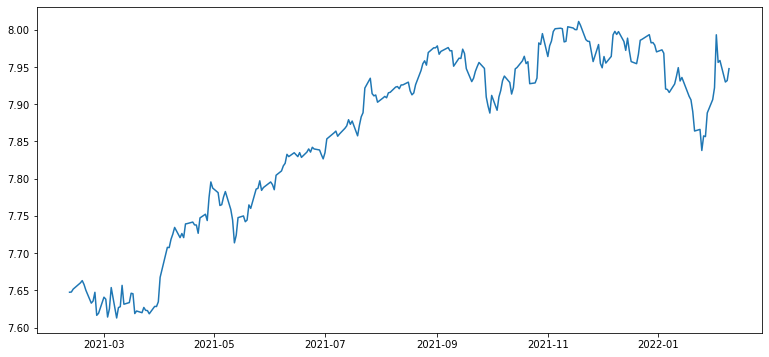

In [31]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

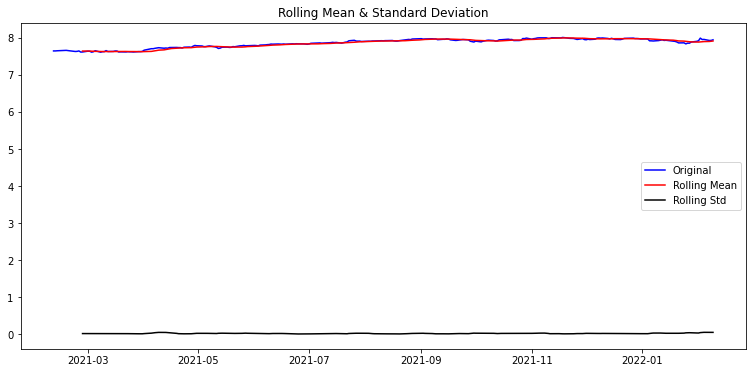

In [32]:
plot_rolling_statistics(ts_log, window=12)

In [33]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test: 
Test Statistic                  -1.622720
p-value                          0.471303
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 사실 로그 변환 전에도 그래프를 정성적으로 보았을 때, 노드에서 봤던 예시만큼 시간 추이에 다른 분산이 증가하는 양상은 아니어서, 로그 변환을 굳이 해야하나 고민했다. 
- 그래서 로그 변환 전후의 ADT Test 결과를 보니 p-value가 0.92에서 0.90으로 소폭 감소하였다. 
- 소폭이라도.. 감소를 했으니 일단 로그 변환은 적용해보기로 했다.  


## Step 3 : 시계열 안정성 분석
`statsmodel` 라이브러리 안에는 `seasonal_decompose` 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능이 있다.  
이 기능을 활용하면 훨신 안정적인 시계열을 분리할 수 있다고 한다. 

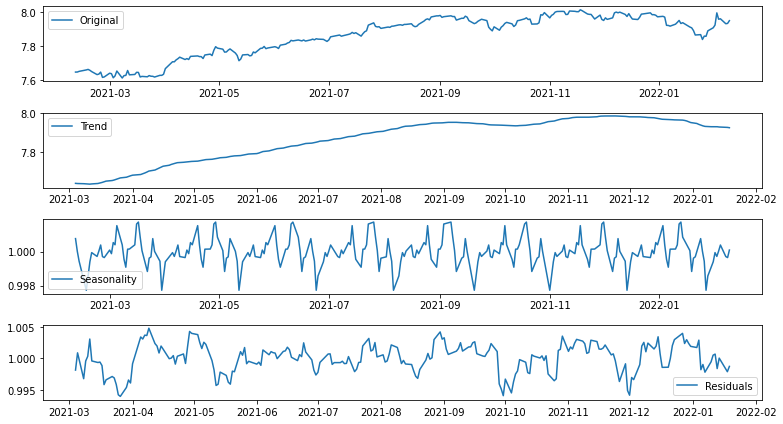

In [34]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세 (시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- multiplicative 모델은 origin = trend * seasonal * residual로 나눠 분석한 모델이다. 
- multiplicative 모델을 활용하려면 데이터에 0이 존재하면 된다. 0이 존재하면 데이터를 분해할 수가 없다고 한다. 
- multiplicative 모델은 분해값들의 곱인 비율로 이루어져 있어서 트렌드에 맞게 seasonal 데이터가 변화한다. 

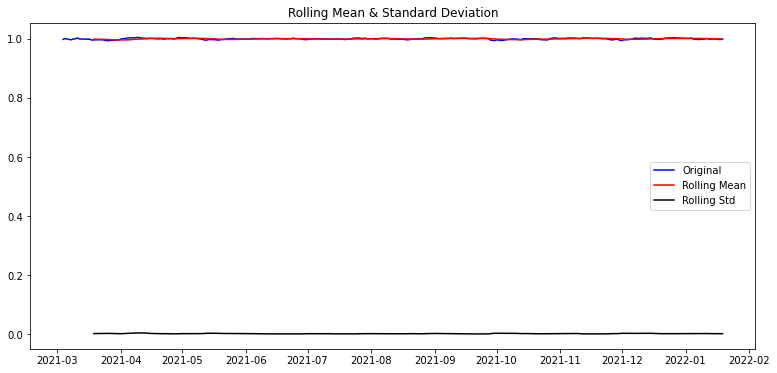

In [35]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [36]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Result of Dickey-Fuller Test: 
Test Statistic                  -5.612618
p-value                          0.000001
#Lags Used                       6.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


- `Decomposing`을 통해 얻은 `Residual`은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열인가..?  


## Step 4 : 학습, 테스트 데이터셋 생성

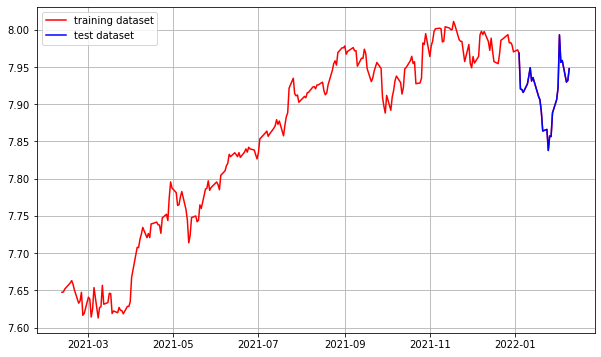

In [37]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

- 시계열 데이터에서 9:1의 비율로 학습 데이터와 테스트 데이터를 분리했다. 시계열 예측이니 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다. 

In [38]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    7.647490
2021-02-11    7.647734
Name: Close, dtype: float64
(227,)
(26,)


## Step 5 : 적정 ARIMA 모수 찾기

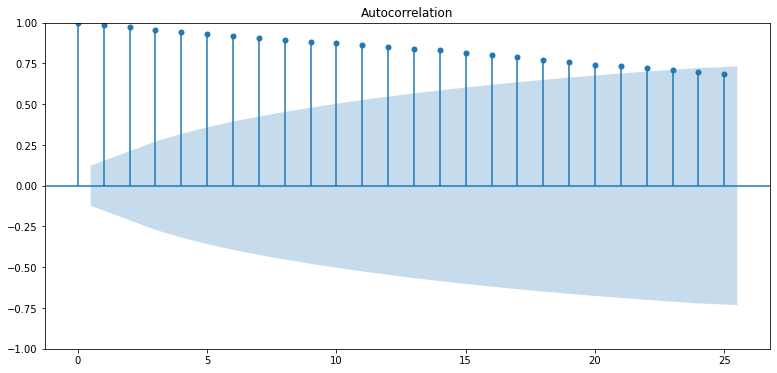

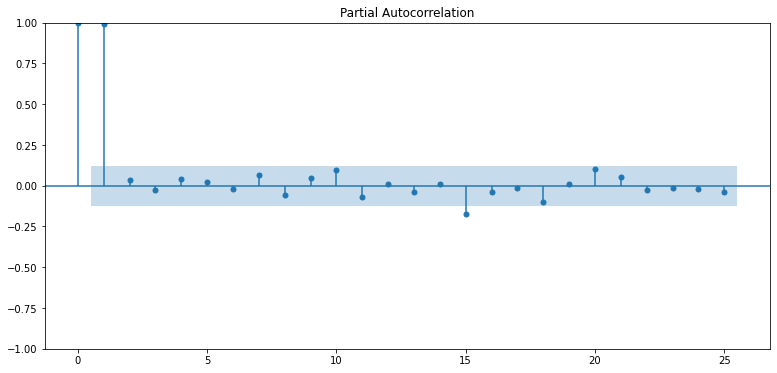

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)  # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 여기도 PACF 그래프를 봤을 때, p=1이 적합할 것이다.
- 위에 대한 것들이 앞에 Apple 데이터와 거의 유사해서... 그대로 썼다. 

Result of Dickey-Fuller Test: 
Test Statistic                -9.805433e+00
p-value                        5.843312e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


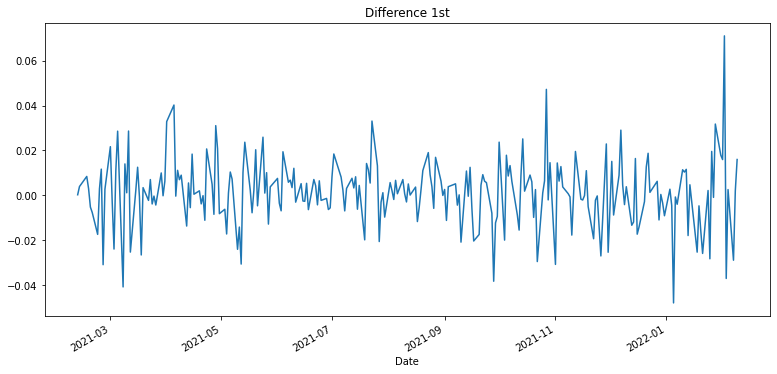

In [40]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Result of Dickey-Fuller Test: 
Test Statistic                -8.232185e+00
p-value                        6.021441e-13
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


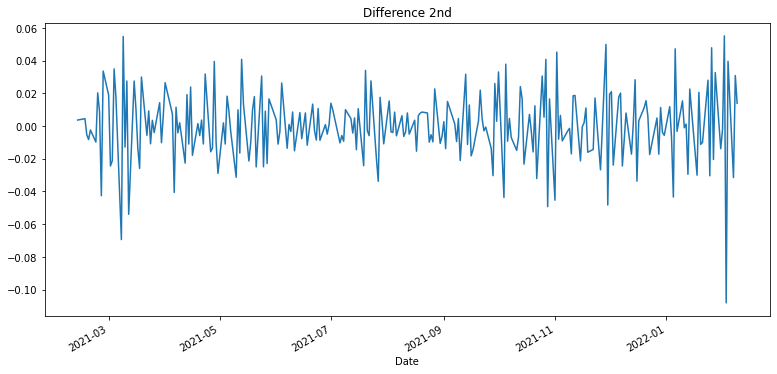

In [41]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- d값은 0으로 줘도 충분할 것 같다. 몇 번 더 시도해봐야겠지만...  


## Step 6 : ARIMA 모델 훈련과 테스트

In [42]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 652.531
Date:                Thu, 10 Feb 2022   AIC                          -1299.062
Time:                        14:24:21   BIC                          -1288.787
Sample:                             0   HQIC                         -1294.916
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8503      0.060    130.143      0.000       7.732       7.969
ar.L1          0.9903      0.006    155.184      0.000       0.978       1.003
sigma2         0.0002   1.42e-05     12.922      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


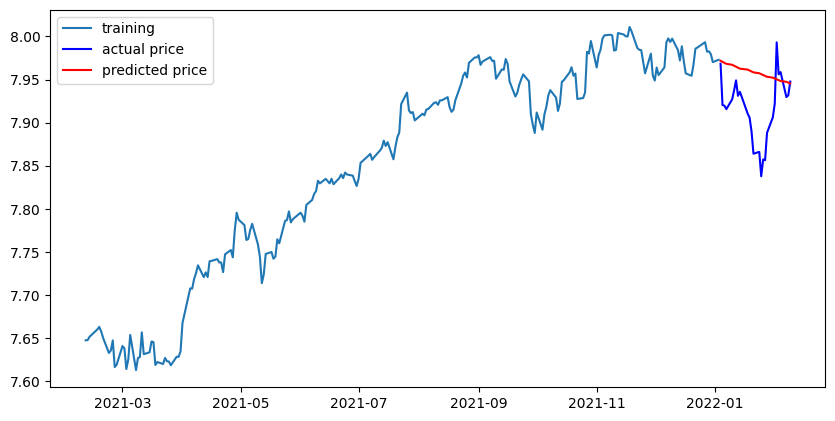

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  24037.022860769455
MAE:  128.83369467440752
RMSE:  155.0387785709416
MAPE: 4.81%


# (3) Microsoft Stock Prediction


## Step 1 : 시계열 데이터 준비

In [45]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    242.820007
2021-02-11    244.490005
2021-02-12    244.990005
2021-02-16    243.699997
2021-02-17    244.199997
Name: Close, dtype: float64

## Step 2 : 각종 전처리 수행
### 결측치 처리

In [46]:
# 결측치 확인. 시계열에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 이 데이터에는 결측치가 없지만, 결측치가 혹시 있다면 처리해야 한다. 결측치는 통계 분석 시에 많은 오류를 일으키며 분석 결과에도 영향을 미치기 때문이다. 
1. 결측치가 있는 데이터를 모두 삭제(drop)
2. 결측치 양 옆의 값들을 이용해 적절히 보간(interpolate)하여 대입

In [47]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

- 시간을 index로 갖는 시계열 데이터이기 때문에 삭제보다는 보간(interpolate)한다.  


### 로그 변환

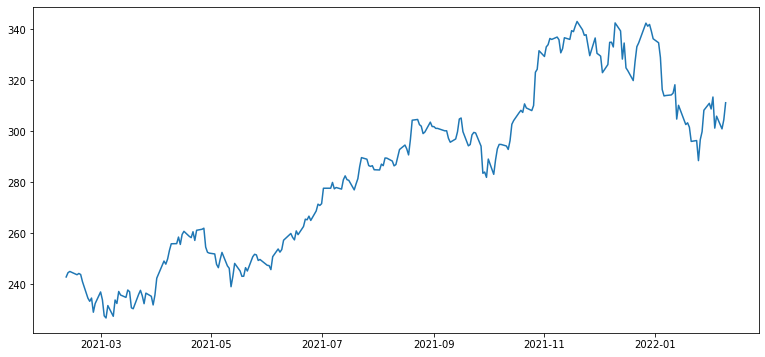

In [48]:
plt.plot(ts)
plt.show()

In [49]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()  # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

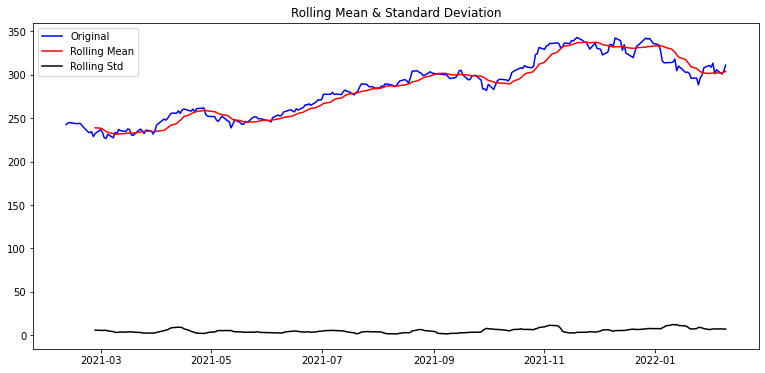

In [50]:
plot_rolling_statistics(ts, window=12)

In [51]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공한느 adfuller 메서드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller 메서드가 리턴한 결과를 정리해 출력
    print('Result of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [52]:
augmented_dickey_fuller_test(ts)

Result of Dickey-Fuller Test: 
Test Statistic                  -1.164619
p-value                          0.688628
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


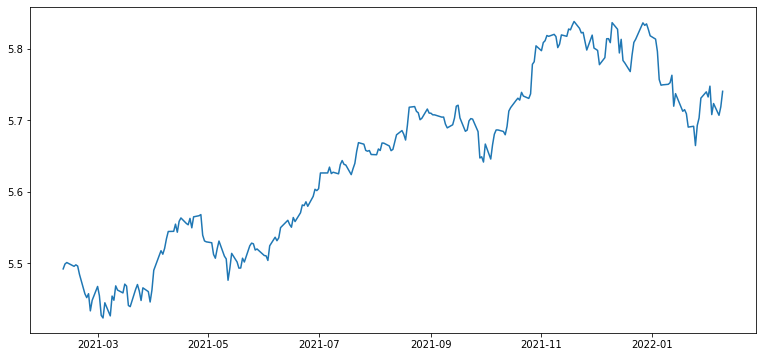

In [53]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

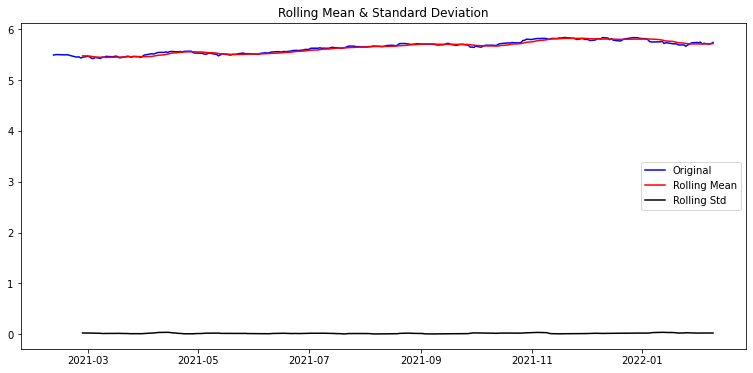

In [54]:
plot_rolling_statistics(ts_log, window=12)

In [55]:
augmented_dickey_fuller_test(ts_log)

Result of Dickey-Fuller Test: 
Test Statistic                  -1.161048
p-value                          0.690124
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 사실 로그 변환 전에도 그래프를 정성적으로 보았을 때, 노드에서 봤던 예시만큼 시간 추이에 다른 분산이 증가하는 양상은 아니어서, 로그 변환을 굳이 해야하나 고민했다. 
- 그래서 로그 변환 전후의 ADT Test 결과를 보니 p-value가 0.92에서 0.90으로 소폭 감소하였다. 
- 소폭이라도.. 감소를 했으니 일단 로그 변환은 적용해보기로 했다.  


## Step 3 : 시계열 안정성 분석
`statsmodel` 라이브러리 안에는 `seasonal_decompose` 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능이 있다.  
이 기능을 활용하면 훨신 안정적인 시계열을 분리할 수 있다고 한다. 

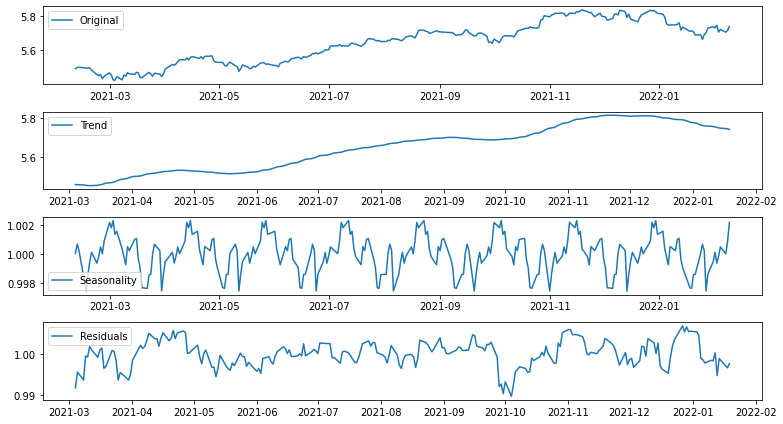

In [56]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend  # 추세 (시간 추이에 따라 나타나는 평균값 변화)
seasonal = decomposition.seasonal  # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid  # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- multiplicative 모델은 origin = trend * seasonal * residual로 나눠 분석한 모델이다. 
- multiplicative 모델을 활용하려면 데이터에 0이 존재하면 된다. 0이 존재하면 데이터를 분해할 수가 없다고 한다. 
- multiplicative 모델은 분해값들의 곱인 비율로 이루어져 있어서 트렌드에 맞게 seasonal 데이터가 변화한다. 

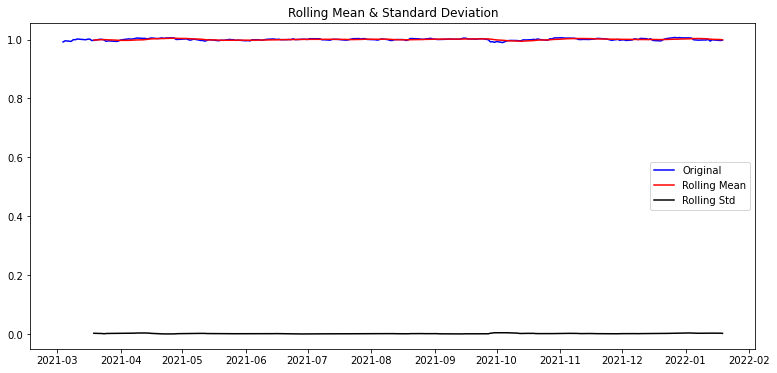

In [57]:
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [58]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Result of Dickey-Fuller Test: 
Test Statistic                  -5.516229
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


- `Decomposing`을 통해 얻은 `Residual`은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열인가..?  


## Step 4 : 학습, 테스트 데이터셋 생성

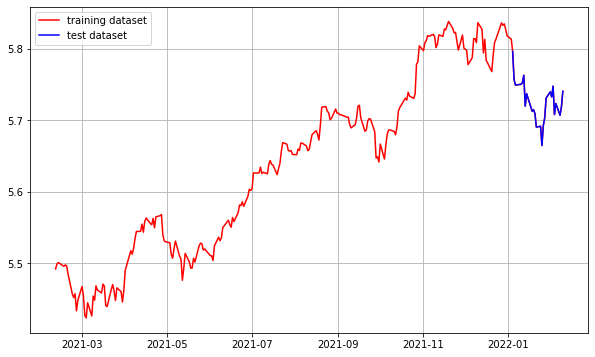

In [59]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

- 시계열 데이터에서 9:1의 비율로 학습 데이터와 테스트 데이터를 분리했다. 시계열 예측이니 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다. 

In [60]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-10    5.492320
2021-02-11    5.499174
Name: Close, dtype: float64
(227,)
(26,)


## Step 5 : 적정 ARIMA 모수 찾기

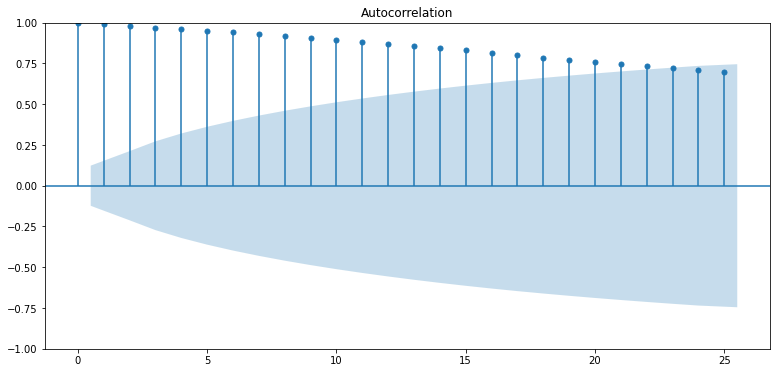

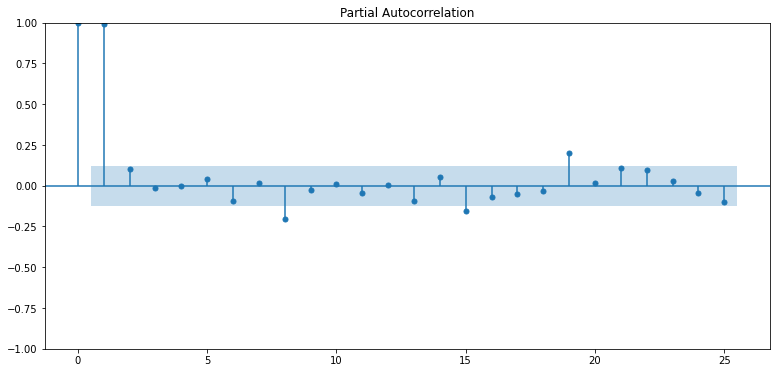

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)  # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 여기서도 위와 동일하다. 

Result of Dickey-Fuller Test: 
Test Statistic                -1.659486e+01
p-value                        1.785608e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


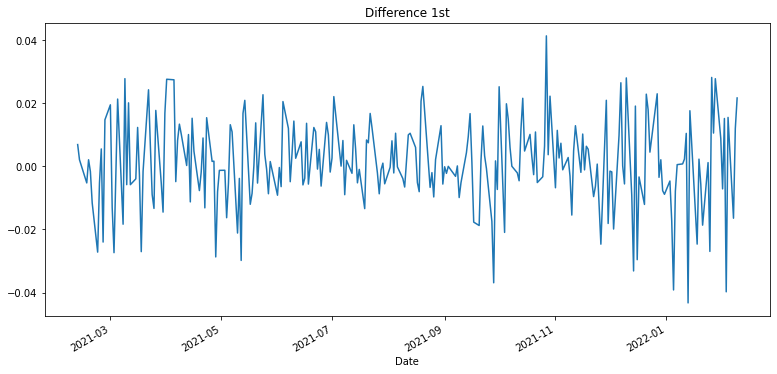

In [62]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Result of Dickey-Fuller Test: 
Test Statistic                -7.319944e+00
p-value                        1.201500e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


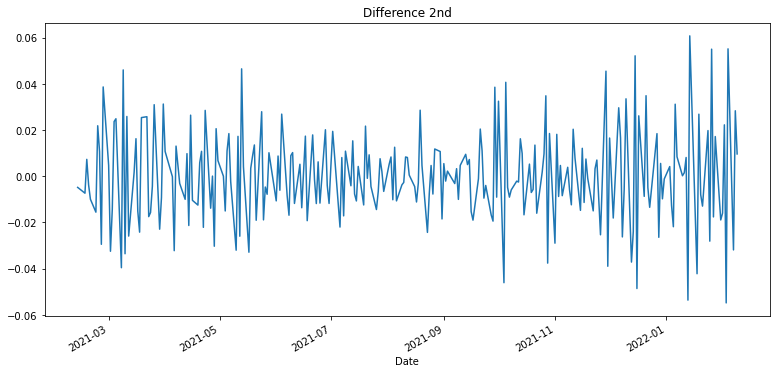

In [63]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- d값은 0으로 줘도 충분할 것 같다. 몇 번 더 시도해봐야겠지만...  


## Step 6 : ARIMA 모델 훈련과 테스트

In [64]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 663.979
Date:                Thu, 10 Feb 2022   AIC                          -1321.959
Time:                        14:24:24   BIC                          -1311.684
Sample:                             0   HQIC                         -1317.812
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6335      0.132     42.809      0.000       5.376       5.891
ar.L1          0.9963      0.006    159.257      0.000       0.984       1.009
sigma2         0.0002   1.44e-05     11.439      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


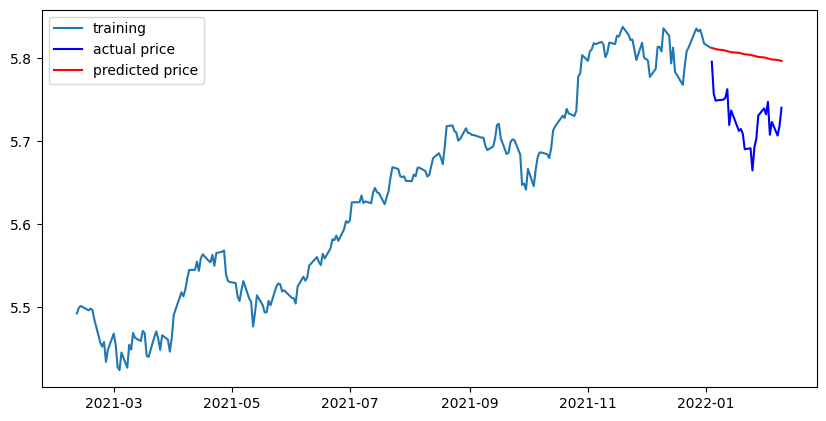

In [65]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  672.4124564811939
MAE:  24.706458533748158
RMSE:  25.93091700039152
MAPE: 8.12%


- Microsoft의 경우 가장 예측 그래프가 이상하게 나왔다...
- 세 종목 다 ACF, PACF를 토대로 봤을 때, p=1, d=0, q=0으로 ARIMA 모수를 설정했는데 Apple과 Google의 경우 비교적 actual price와 비슷하게 흘러간 것에 비해 Microsoft는 그래프가 가장 많이 빗나갔고, MAPE도 가장 높게 나왔다. 
- 통계학적으로 각 시계열 데이터를 안정화할 수 있도록 여러 시도를 할 수도 있을 것 같은데... 사실 이번 노드를 이해하는데 너무 오랜 시간을 쓰고 고생을 해서인지 더 쳐다보기가 싫다... 아마 시계열 데이터의 예측에는 여러 외부요인이 작용하기 때문에 모수값을 어렵사리 ARIMA에 줘도, 제대로 예측하기가 힘든 것이 아닌가 하는 추측을 해본다...